In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

In [2]:
start_time = time.time()

print("Loading the resampled training data...")

train_data = pd.read_csv('/kaggle/input/drone-dft/train_resampled.csv')

Loading the resampled training data...


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Columns: 1025 entries, feature_0 to label
dtypes: float64(1024), int64(1)
memory usage: 2.3 MB


In [4]:
y_train_resampled = train_data['label']
X_train_resampled = train_data.drop('label', axis=1)

In [5]:
print(f"Training features shape: {X_train_resampled.shape}")
print(f"Training labels shape: {y_train_resampled.shape}")
print(f"Class distribution: {y_train_resampled.value_counts()}")

Training features shape: (298, 1024)
Training labels shape: (298,)
Class distribution: label
1    149
0    149
Name: count, dtype: int64


In [9]:

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'gamma': 0,
    'n_estimators': 100,
    'random_state': 42,
    'tree_method': 'hist',
    'device': 'cuda' 
}


print("Performing 10-fold cross-validation...")
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
xgb_model = xgb.XGBClassifier(**xgb_params)

cv_scores = cross_val_score(xgb_model, X_train_resampled, y_train_resampled, cv=kfold, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

Performing 10-fold cross-validation...
Cross-validation accuracy: 0.9494 (±0.0437)


In [10]:
param_grid = {
    'eta': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}


base_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    tree_method='hist',
    device='cuda'
)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    verbose=2,
    n_jobs=1  
)

print("Starting grid search for optimal parameters...")
grid_search.fit(X_train_resampled, y_train_resampled)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


Starting grid search for optimal parameters...
Fitting 10 folds for each of 729 candidates, totalling 7290 fits
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, eta=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6; total time=   0.4s
[CV] END cols

In [12]:
# Train final model with best parameters
best_model = grid_search.best_estimator_
print("\nTraining final model with best parameters...")
best_model.fit(X_train_resampled, y_train_resampled)

# Save the model
print("Saving the model...")
best_model.save_model('drone_detection_model.json')
print("Model saved to 'drone_detection_model.json'")


Training final model with best parameters...
Saving the model...
Model saved to 'drone_detection_model.json'


In [16]:
import pickle
with open('xgboost_scaled.pkl', 'wb') as f:
    pickle.dump(best_model, f)


Looking for test data...
Making predictions on test data...

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.50      0.62        16
           1       0.81      0.95      0.88        37

    accuracy                           0.81        53
   macro avg       0.81      0.72      0.75        53
weighted avg       0.81      0.81      0.80        53


Confusion Matrix:
[[ 8  8]
 [ 2 35]]


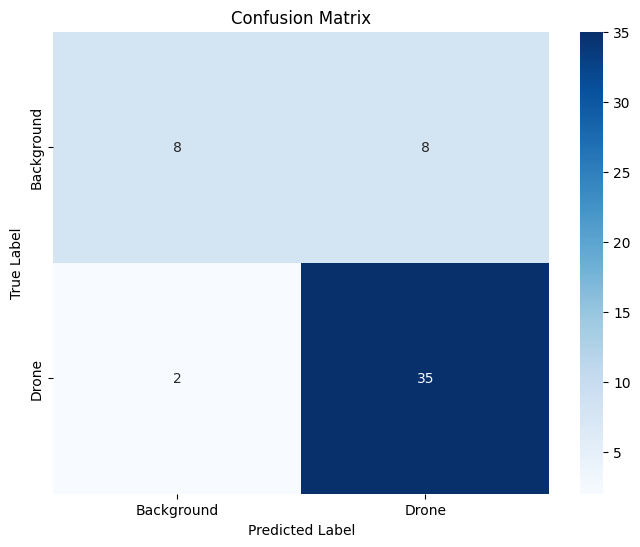

Confusion matrix plot saved to 'confusion_matrix.png'


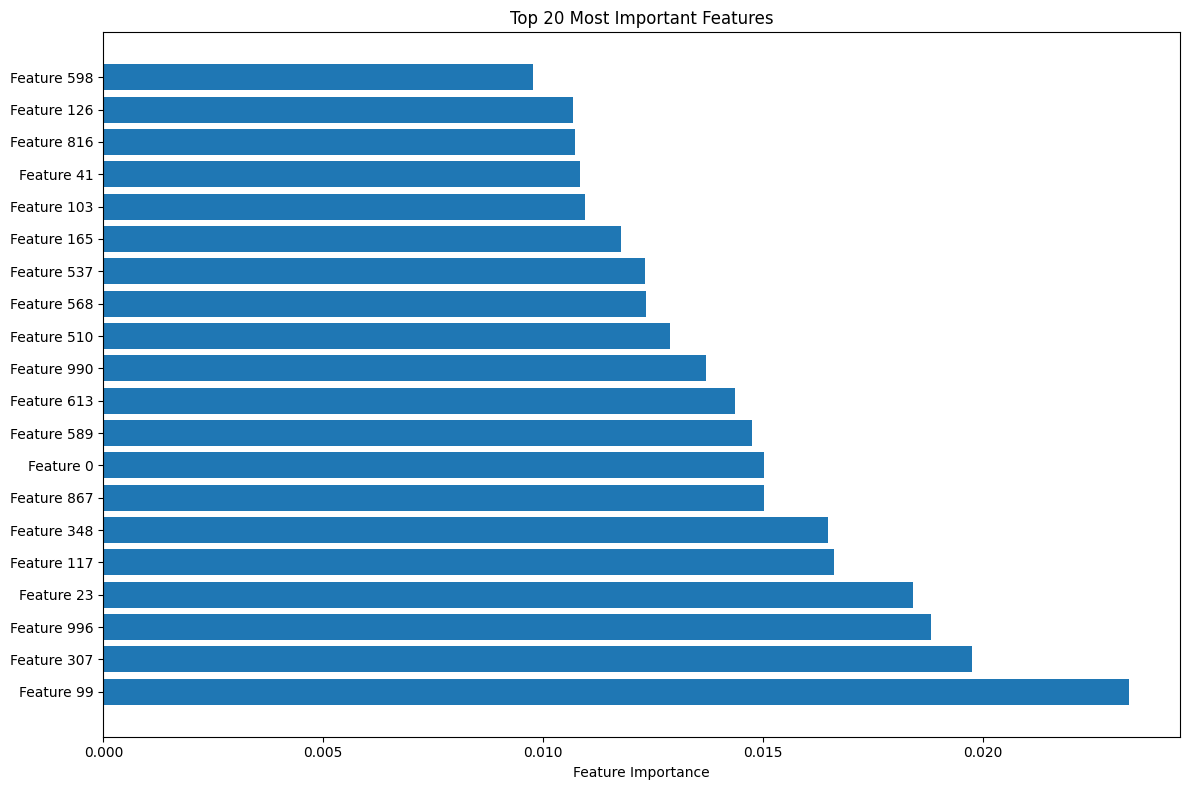

Feature importance plot saved to 'feature_importance.png'

Total execution time: 5593.86 seconds (93.23 minutes)


In [14]:
print("\nLooking for test data...")
try:
    test_data = pd.read_csv('/kaggle/input/test-data-drone-drt/test.csv')
    X_test = test_data.drop('label', axis=1)
    y_test = test_data['label']
    
    # Scale test data using the same scaler
    # X_test_scaled = scaler.transform(X_test)
    
    # Make predictions
    print("Making predictions on test data...")
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate evaluation metrics
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred)
    print(report)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Background', 'Drone'],
                yticklabels=['Background', 'Drone'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()
    print("Confusion matrix plot saved to 'confusion_matrix.png'")
    
    # Feature importance
    plt.figure(figsize=(12, 8))
    feature_importance = best_model.feature_importances_
    sorted_idx = np.argsort(feature_importance)[::-1][:20]  # Top 20 features
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [f"Feature {i}" for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
    print("Feature importance plot saved to 'feature_importance.png'")
    
except FileNotFoundError:
    print("Test data file not found. You will need to create test_data.csv with your test set.")
    print("Alternatively, you can modify this script to create test data:")
    print("1. Load your full dataset")
    print("2. Use train_test_split to create X_train, X_test, y_train, y_test")
    print("3. Save X_test and y_test to test_data.csv for future evaluations")

# Calculate and print total execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")